## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Mollusca - Zo </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)
    * [5.1. Custom Sequential](#customseq)
    * [5.2. MobileNetV2](#MobileNetV2)
    * [5.3. EfficientNetB0](#EfficientNetB0)
* [6. Hyperparameter Tuning](#hptuning)
    * [6.1. Hyperparameter Tuning for Custom Sequential Model](#hptcustomseq)
    * [6.2. Train Custom Sequential with the Best Parameter Combination](#traincustseq)
    * [6.3. Save the Best Custom Sequential Model](#savecustseq)
    * [6.4. Hyperparameter Tuning for MobileNetV2](#hptMobileNetV2)
    * [6.5. Train MobileNetV2 with the Best Parameter Combination](#trainbestparmobilenet)
    * [6.6. Save the Best MobileNetV2 Model](#savebestmobilenet)
* [7. Test the Models](#test)
    * [7.1. Test Custom Sequential](#testcustomseq)
    * [7.2. Test MobileNetV2](#testMobileNetV2)

# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Mollusca** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random, itertools

# sklearn libraries
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping 

# Warnings filter
import warnings
warnings.filterwarnings('ignore')

# import pipeline_methods.py methods
import sys
import importlib
import pipeline_methods
importlib.reload(pipeline_methods)
from pipeline_methods import *

# from pipeline_methods.py
from pipeline_methods import create_generators, visualize_pipeline_processed, evaluate_f1

# for reproducibility in python structures (like lists, dicts, etc.)
os.environ['PYTHONHASHSEED'] = '4'

2025-05-01 13:51:40.868769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Mollusca Phylum.

In [2]:
# Set the root directory where images are stored 
image_root_dir = 'rare_species'

In [3]:
# Load the DataFrame from the CSV file
mollusca_train = pd.read_csv("train_test_splits/mollusca_train.csv")
mollusca_train.head(3)

eol_content_id  eol_page_id   kingdom    phylum     family  \
0        30003937     46473744  animalia  mollusca  cardiidae   
1         2744855       449459  animalia  mollusca  unionidae   
2        12835846     46454284  animalia  mollusca    conidae   

                                           file_path  
0  mollusca_cardiidae/30003937_46473744_eol-full-...  
1  mollusca_unionidae/2744855_449459_eol-full-siz...  
2  mollusca_conidae/12835846_46454284_eol-full-si...

In [4]:
# Load the DataFrame from the CSV file
mollusca_test = pd.read_csv("train_test_splits/mollusca_test.csv")
mollusca_test.head(3)

eol_content_id  eol_page_id   kingdom    phylum      family  \
0        22271558     46454284  animalia  mollusca     conidae   
1        12800653      4792502  animalia  mollusca  haliotidae   
2        13998439     46473744  animalia  mollusca   cardiidae   

                                           file_path  
0  mollusca_conidae/22271558_46454284_eol-full-si...  
1  mollusca_haliotidae/12800653_4792502_eol-full-...  
2  mollusca_cardiidae/13998439_46473744_eol-full-...

In [5]:
mollusca_train.shape, mollusca_test.shape

((159, 6), (40, 6))

Number of training examples per family in Mollusca phylum:

In [6]:
mollusca_train['family'].value_counts()

family
cardiidae     48
unionidae     39
conidae       24
haliotidae    24
zonitidae     24
Name: count, dtype: int64

Number of test examples per family:

In [7]:
mollusca_test['family'].value_counts()

family
cardiidae     12
unionidae     10
conidae        6
haliotidae     6
zonitidae      6
Name: count, dtype: int64

# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

### `ImageDataGenerator`
is a Keras utility that handles image preprocessing and real-time data augmentation during model training. It allows us to:

- **Preprocess images**: Normalize pixel values (e.g., rescale from [0, 255] to [0, 1]).
- **Augment data**: Randomly transform images (e.g., rotate, zoom, flip) to artificially increase the diversity of the training dataset and improve model generalization.
- **Generate batches**: Efficiently load images in small batches directly from a DataFrame, rather than storing the entire dataset in memory.

### `create_generators()`
function builds and returns three Keras data generators for model training and testing:

- **`train_generator`**: Loads training images from the `mollusca_train` DataFrame, resizes them to the specified `image_size`, applies real-time data augmentation (rotation, zoom, flipping), normalizes pixel values to [0, 1], and generates batches of images for training.

- **`val_generator`**: Loads a fixed 20% validation subset of the training data, applies the same resizing and normalization as the training generator, but no augmentation. This data is then used to evaluate model performance during training.

- **`test_generator`**: Loads test images from the `mollusca_test` DataFrame, resizes and normalizes them, but does not apply augmentation or shuffling — ensuring predictions align with the original order of the test set.

By using `ImageDataGenerator` in combination with `flow_from_dataframe()`, we build flexible and memory-efficient pipeline that prepares and feeds images to the model during training, validation, and testing.


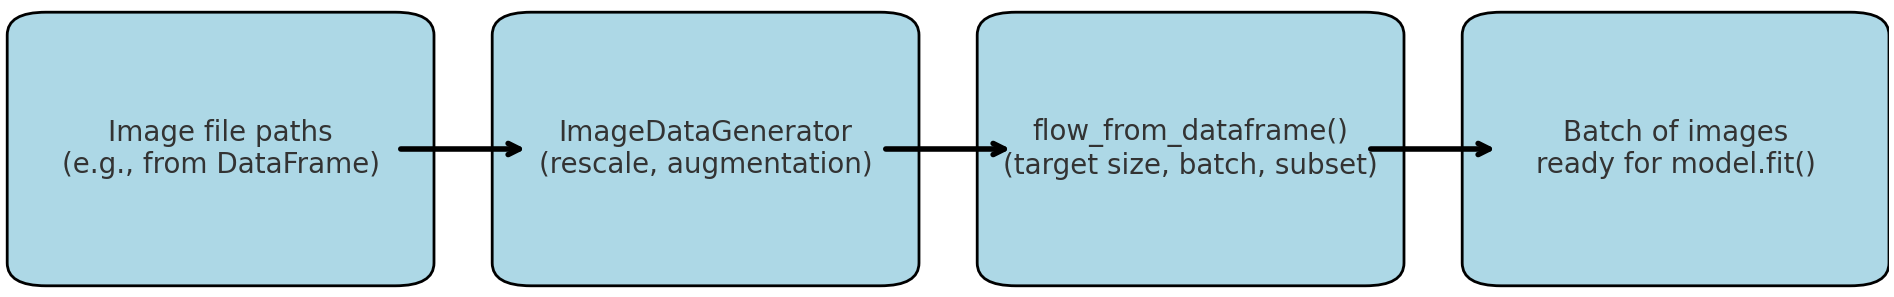

In [8]:
# Call the function to create generators 
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=(128, 128),   
    batch_size=16            
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


Side by side comparison of raw images vs preprocessed ones

Found 5 validated image filenames.


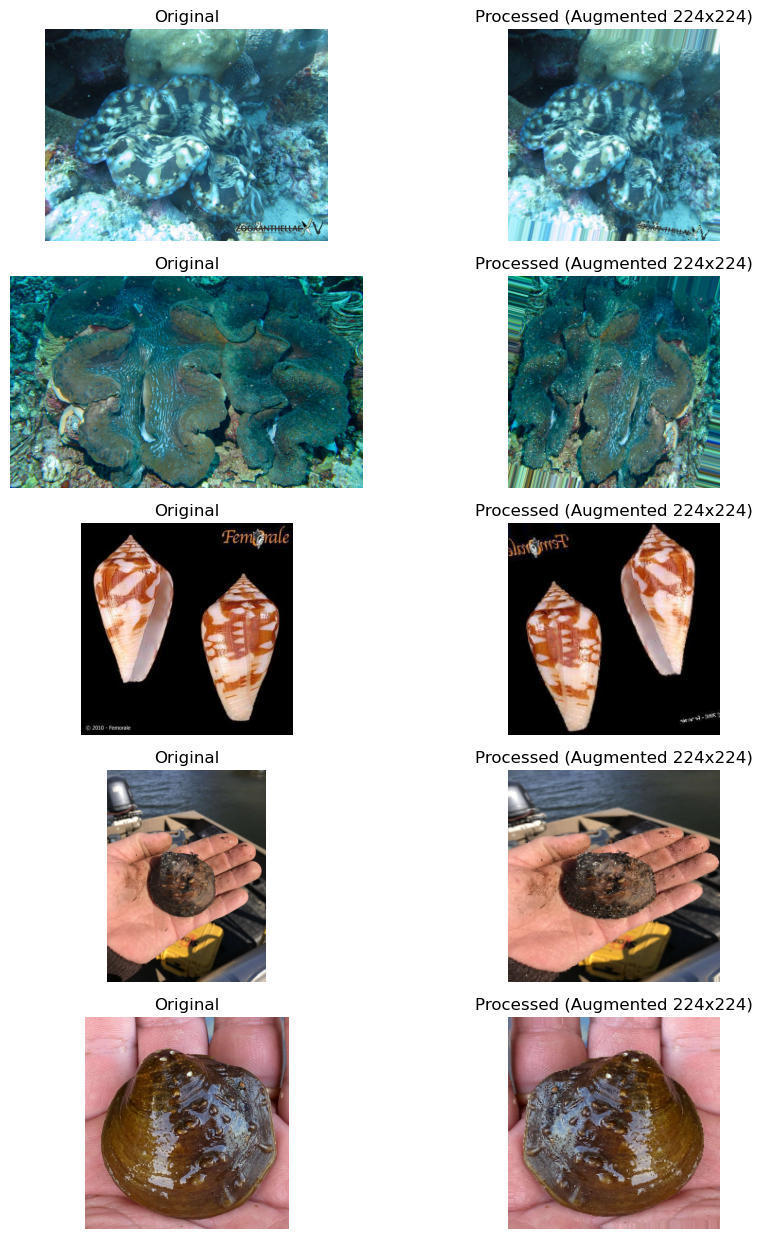

In [9]:
visualize_pipeline_processed(
    train_df=mollusca_train,
    image_root_dir='rare_species',
    image_size=(224, 224),
    num_samples=5
)

# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

## 5.1. Custom Sequential <a class="anchor" id="customseq"></a>

### `Custom Sequential Model`
is a simple CNN designed to classify Mollusca images into its five classes. It consists of:
- **Input layer**: 
  - Accepts resized RGB images of shape `(128, 128, 3)`.
- **Convolutional Block 1**:
  - `Conv2D(32, (3, 3), activation='relu')`: Applies 32 learnable filters of size 3×3 across the input, detecting local patterns by sliding the filters spatially and computing dot products.

  - `MaxPooling2D(2, 2)`: Downsamples feature maps by selecting the maximum value within each 2×2 region, reducing spatial dimensions and computation.
- **Convolutional Block 2**:
  - `Conv2D(64, (3, 3), activation='relu')`: Applies 64 new filters to the previous block’s feature maps, learning more complex patterns based on prior layer outputs.

  - `MaxPooling2D(2, 2)`: Further downsamples to focus on important information.
- **Convolutional Block 3**:
  - `Conv2D(128, (3, 3), activation='relu')`: Applies 128 filters to extract increasingly rich and detailed features.

  - `MaxPooling2D(2, 2)`: Continues dimensionality reduction for dimensionality reduction and efficiency.
- **Flatten Layer**:
  - `Flatten()`: Converts 2D feature maps into a 1D vector for dense layers.
- **Dense Block**:
  - `Dense(128, activation='relu')`: Learns combinations of extracted features.
  
  - `Dropout(0.5)`: Reduces overfitting by randomly disabling neurons during training.
- **Output Layer**:
  - `Dense(5, activation='softmax')`: Outputs probabilities for the five Mollusca classes.

The model is compiled using **Adam** optimizer, **categorical crossentropy** loss, and tracks **accuracy** as the performance metric.


Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


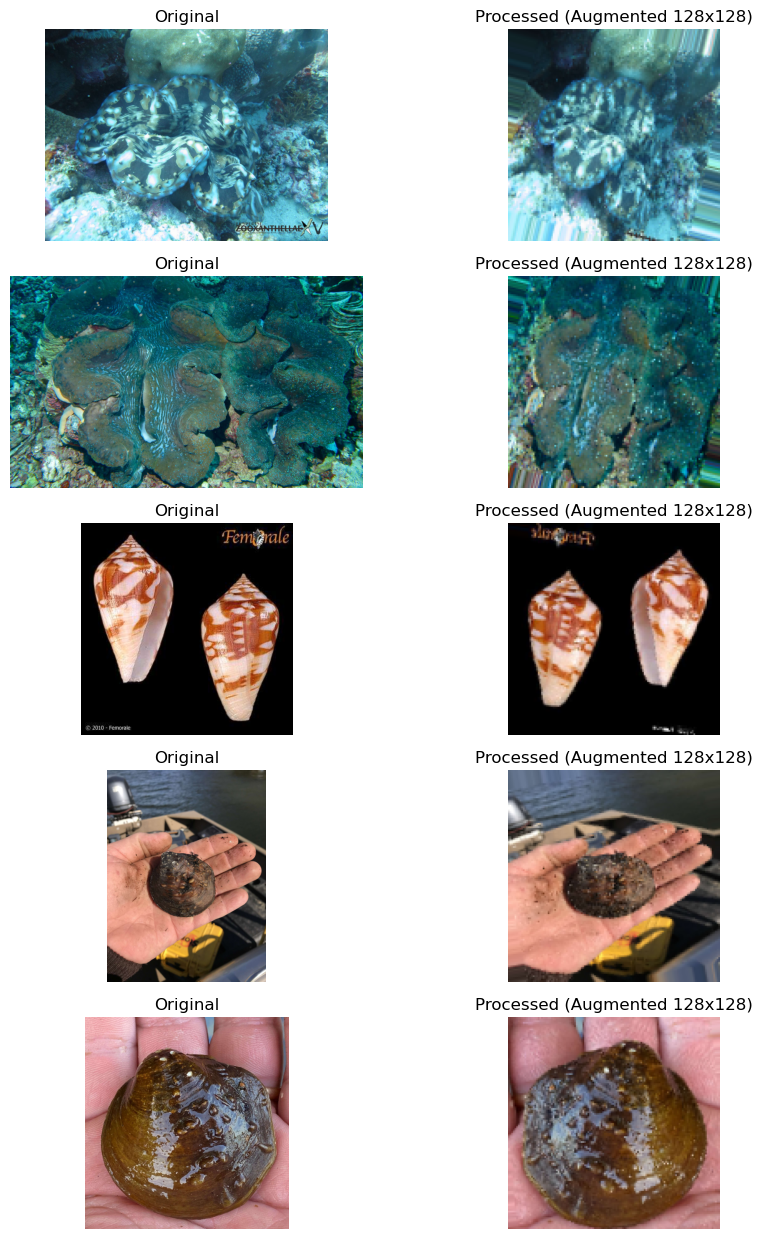

In [10]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=(128, 128),   
    batch_size=16            
)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(
    train_df=mollusca_train,
    image_root_dir='rare_species',
    image_size=(128, 128),
    batch_size=1,    
    num_samples=5
)

In [11]:
# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

model1 = models.Sequential([
    layers.Input(shape=(128, 128, 3)),  # RGB images

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  

    # Output Layer
    layers.Dense(5, activation='softmax')  # 5 classes
])

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [12]:
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,   
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], # validation loss is the default 
    verbose = 1,           # 1 is the default (progress bar per epoch)             
    class_weight=None      # Do not give different importance to different classes in this run and see what happens
)
# Execution time: 4m 17.7s

Epoch 1/50
8/8 [==============================] - 22s 2s/step - loss: 1.7599 - accuracy: 0.3203 - val_loss: 1.4689 - val_accuracy: 0.5161
Epoch 2/50
8/8 [==============================] - 20s 3s/step - loss: 1.4571 - accuracy: 0.3906 - val_loss: 1.2549 - val_accuracy: 0.5484
Epoch 3/50
8/8 [==============================] - 14s 2s/step - loss: 1.3770 - accuracy: 0.3828 - val_loss: 1.0458 - val_accuracy: 0.6129
Epoch 4/50
8/8 [==============================] - 16s 2s/step - loss: 1.2532 - accuracy: 0.5156 - val_loss: 0.9195 - val_accuracy: 0.6452
Epoch 5/50
8/8 [==============================] - 14s 2s/step - loss: 1.1212 - accuracy: 0.5547 - val_loss: 0.9065 - val_accuracy: 0.6774
Epoch 6/50
8/8 [==============================] - 16s 2s/step - loss: 1.1569 - accuracy: 0.5469 - val_loss: 0.9406 - val_accuracy: 0.6452
Epoch 7/50
8/8 [==============================] - 14s 2s/step - loss: 1.1096 - accuracy: 0.5625 - val_loss: 0.9042 - val_accuracy: 0.6452
Epoch 8/50
8/8 [==================

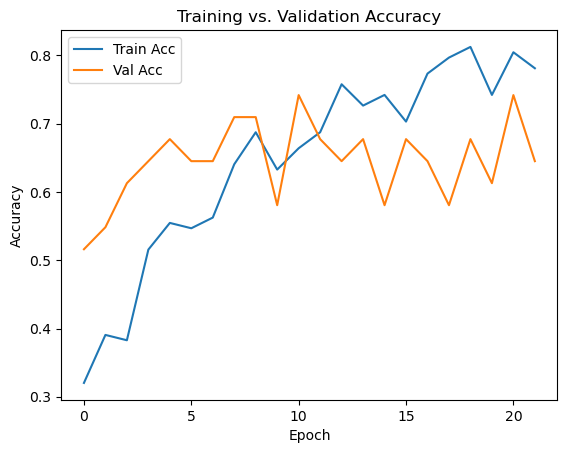

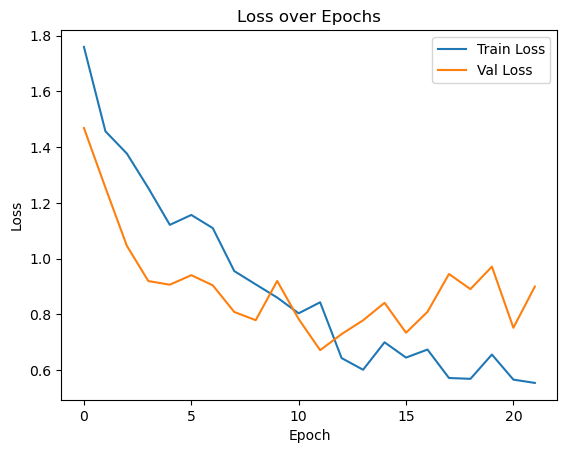

In [13]:
# plot the results
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Loss
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

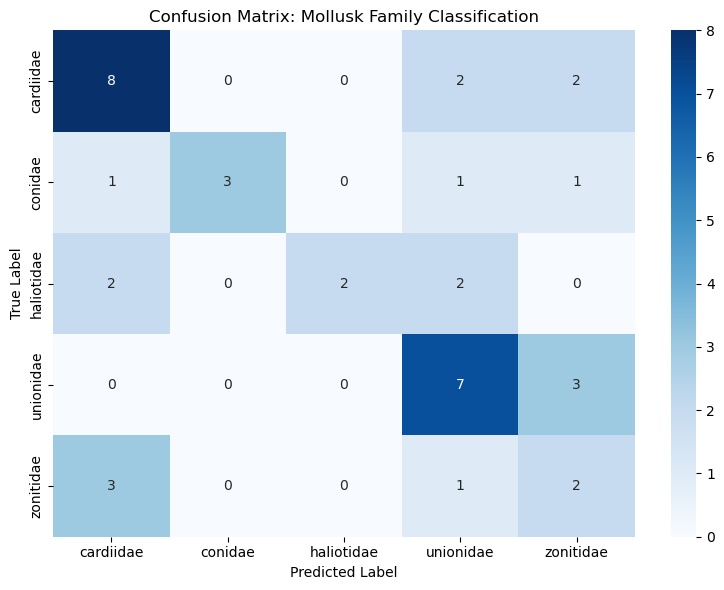

In [14]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model1.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [15]:
# 1. Evaluate on training set
train_loss, train_accuracy = model1.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = model1.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(model1, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 0.7500
Training Loss: 0.6305
Validation Accuracy: 0.6774
Validation Loss: 0.7150
Validation F1 Score: 0.1980


- some minority classes did well than the other (but might be a good idea to try class weights when hypertuning)

## 5.2. MobileNetV2 <a class="anchor" id="MobileNetV2"></a>

### `MobileNetV2 Transfer Learning Model`
We build a CNN on top of MobileNetV2 as a feature extractor to classify Mollusca images into five classes. Our model consists of:
- **Base Model**:
  - `MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')`: Loads MobileNetV2 without the original classification head, using pretrained ImageNet weights. The base is frozen to leverage pretrained features.
- **Global Average Pooling Layer**:
  - `GlobalAveragePooling2D()`: Reduces the spatial dimensions (width and height) by computing the average of each feature map.
- **Dropout Layer**:
  - `Dropout(0.3)`: Randomly deactivating 30% of neurons during training, helping to reduce overfitting.
- **Dense Block**:
  - `Dense(128, activation='relu')`: A fully connected layer that learns combinations of extracted feature maps.
- **Output Layer**:
  - `Dense(5, activation='softmax')`: Outputs a probability distribution over the five Mollusca classes.

The model is compiled using **Adam** optimizer with a learning rate of `1e-4`, uses **categorical crossentropy** as the loss function, and tracks **accuracy** as the evaluation metric.

`MobileNetV2` is lightweight and efficient pre-trained model, ideal when computational resources and/or data is limited. https://keras.io/api/applications/mobilenet/

### About `Freezing` and `Unfreezing` Layers in Transfer Learning

When using a pretrained model, we can choose between **freezing** or **unfreezing** layers depending on available data and project goals:

#### Freeze All Layers (Feature Extraction)
- Use the pretrained model as a **fixed feature extractor**.
- **Best when:**
  - You have a **small dataset**
  - Your images are **similar to ImageNet**

#### Unfreeze Some Layers (Fine-Tuning)
- After training the top classifier, unfreeze the **last few layers** of the pretrained model.
- Allows the model to **adapt** more deeply to your specific data.
- **Best when:**
  - You have **more data**
  - Your images are **very different from ImageNet** 

In [16]:
# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Load base model without top layer
base_model = MobileNetV2(
    input_shape=(128, 128, 3), # Match the resized image shape
    include_top=False,         # Don't include the original classifier
    weights='imagenet'         # Use ImageNet pretrained weights 
)

# Freeze base model so we only train the new layers for now
base_model.trainable = False

# Build custom model
model2 = models.Sequential([
    base_model,                                # Feature extractor
    layers.GlobalAveragePooling2D(),           # Pool over spatial dimensions
    layers.Dropout(0.3),                       # Regularization layer
    layers.Dense(128, activation='relu'),      # Fully connected layer
    layers.Dense(5, activation='softmax')      # Output layer (5 mollusk families)
])

# Compile model
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 1646

In [17]:
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,           
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], # validation loss is the default
    verbose=1            # default (progress bar per epoch) 
)
# Execution time: 6m 33.5s

Epoch 1/50
8/8 [==============================] - 21s 2s/step - loss: 2.6948 - accuracy: 0.1797 - val_loss: 1.6903 - val_accuracy: 0.3548
Epoch 2/50
8/8 [==============================] - 10s 1s/step - loss: 1.7159 - accuracy: 0.3359 - val_loss: 1.4880 - val_accuracy: 0.4516
Epoch 3/50
8/8 [==============================] - 10s 1s/step - loss: 1.3956 - accuracy: 0.4766 - val_loss: 1.4399 - val_accuracy: 0.3871
Epoch 4/50
8/8 [==============================] - 10s 1s/step - loss: 1.1169 - accuracy: 0.5781 - val_loss: 1.1100 - val_accuracy: 0.6452
Epoch 5/50
8/8 [==============================] - 10s 1s/step - loss: 1.0123 - accuracy: 0.6094 - val_loss: 1.0329 - val_accuracy: 0.6452
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.8450 - accuracy: 0.7031 - val_loss: 0.9241 - val_accuracy: 0.6452
Epoch 7/50
8/8 [==============================] - 9s 1s/step - loss: 0.7854 - accuracy: 0.7188 - val_loss: 0.8337 - val_accuracy: 0.7419
Epoch 8/50
8/8 [===================

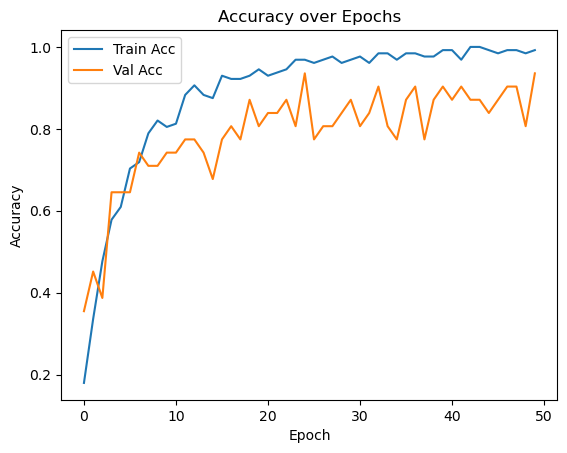

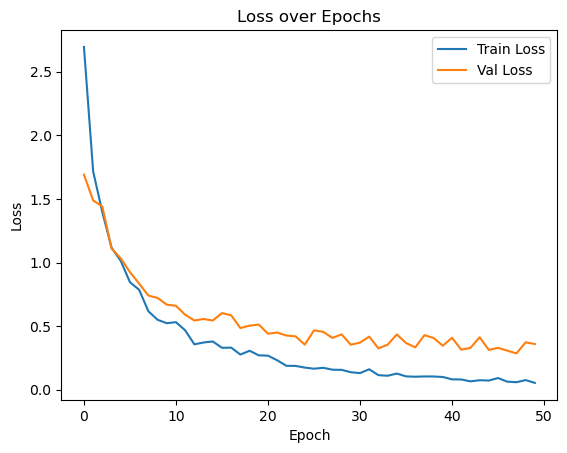

In [18]:
# Accuracy
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

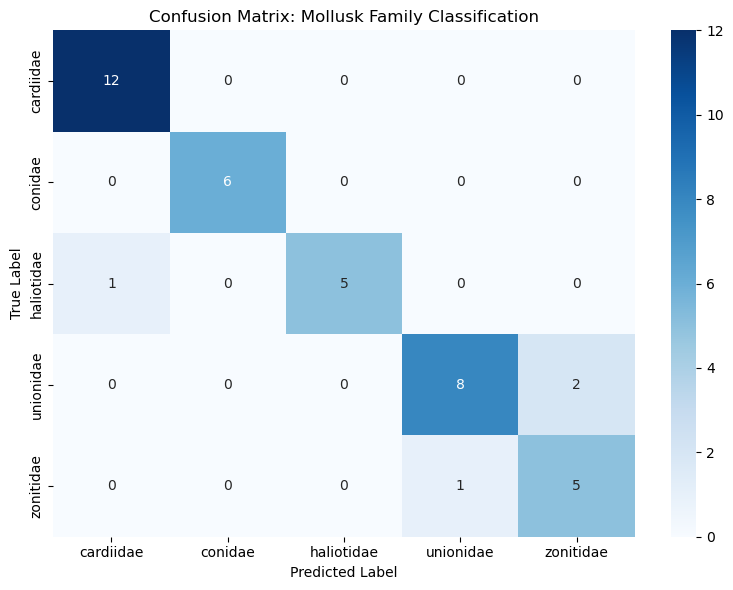

In [19]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model2.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [20]:
# 1. Evaluate on training set
train_loss, train_accuracy = model2.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = model2.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(model2, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 1.0000
Training Loss: 0.0255
Validation Accuracy: 0.8710
Validation Loss: 0.3242
Validation F1 Score: 0.1580


- Very promising results 
- Most likely no class weights needed if fine tuning

## 5.3. EfficientNetB0 <a class="anchor" id="EfficientNetB0"></a>

### `EfficientNetB0 Transfer Leaning Model`
built on a compact CNN architecture, which we use as a feature extractor to classify our Mollusca images. Our design consists of:
- **Base Model**:
  - `EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')`: Loads EfficientNetB0 without the original classification head, using pretrained ImageNet weights. 
- **Global Average Pooling Layer**:
  - `GlobalAveragePooling2D()`: Collapses each feature map into a single value by averaging spatial dimensions, significantly reducing the number of parameters.
- **Dropout Layer**:
  - `Dropout(0.3)`: Randomly disabling 30% of neurons during training, helping to prevent overfitting.
- **Dense Block**:
  - `Dense(128, activation='relu')`: A fully connected layer that learns combinations of extracted features.
- **Output Layer**:
  - `Dense(5, activation='softmax')`: Outputs a probability distribution over the five Mollusca families.

The model is compiled using **Adam** optimizer with a learning rate of `1e-4`, uses **categorical crossentropy** as the loss function, and tracks **accuracy** as the evaluation metric.

EfficientNetB0 was chosen because it provides an excellent trade-off between model size and accuracy. It is well-suited for limited datasets such as ours. https://keras.io/api/applications/efficientnet/

Let's try image size of 224x224

Found 128 validated image filenames belonging to 5 classes.


Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


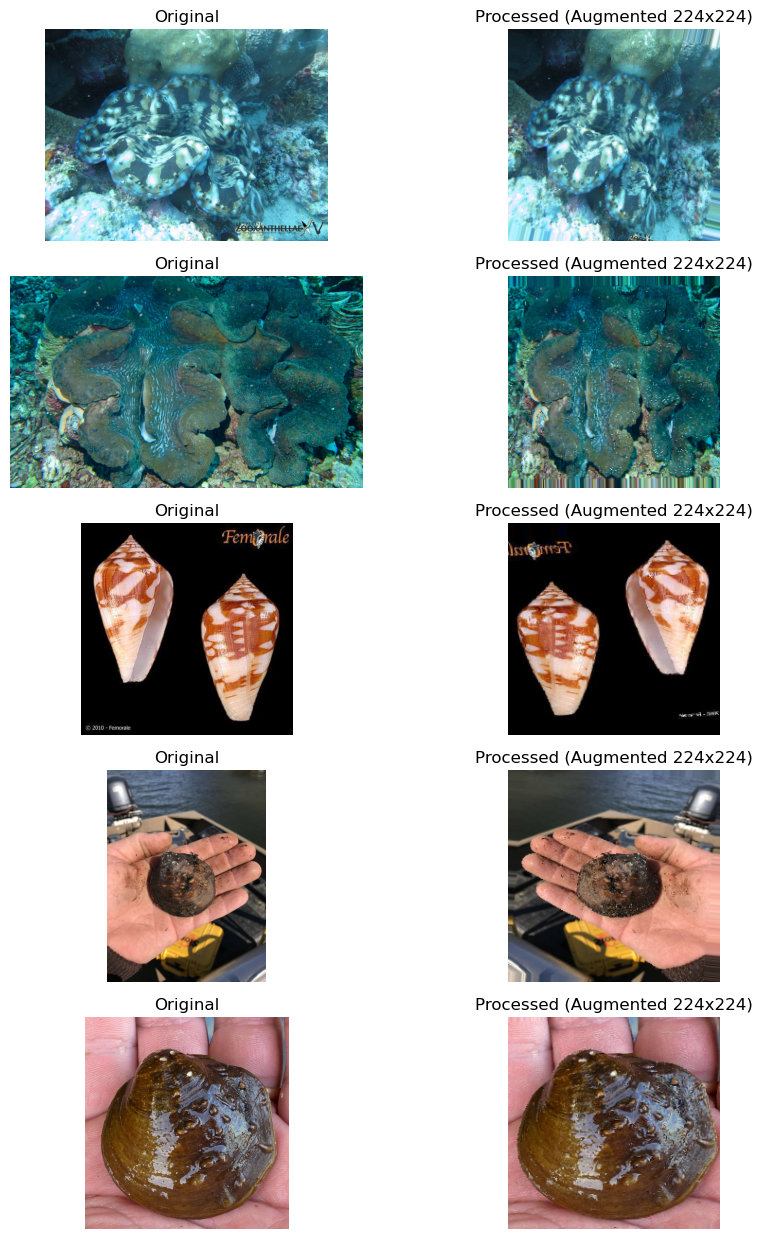

In [21]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=(224, 224),   # Resized to 224x224 for EfficientNetB0
    batch_size=16            
)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(
    train_df=mollusca_train,
    image_root_dir='rare_species',
    image_size=(224, 224),
    num_samples=5
)

In [22]:
# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Load EfficientNetB0 without the top classification layer
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),   # match EfficientNetB0 default input size
    include_top=False,           # Remove the original classifier head
    weights='imagenet'           # Use pre-trained ImageNet weights
)

# Freeze the base model to use it as a fixed feature extractor
base_model.trainable = False

# Build your custom classifier head
model3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Compile the model
model3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 4214184 (16.08 MB)
Trainable params: 164

In [23]:
history3 = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)
# Ececution time: 3m 28.4s

Epoch 1/50
8/8 [==============================] - 24s 2s/step - loss: 1.5591 - accuracy: 0.3125 - val_loss: 1.6431 - val_accuracy: 0.2581
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 1.5689 - accuracy: 0.3047 - val_loss: 1.6717 - val_accuracy: 0.2581
Epoch 3/50
8/8 [==============================] - 15s 2s/step - loss: 1.5539 - accuracy: 0.3125 - val_loss: 1.6860 - val_accuracy: 0.2581
Epoch 4/50
8/8 [==============================] - 16s 2s/step - loss: 1.5400 - accuracy: 0.3125 - val_loss: 1.6947 - val_accuracy: 0.2581
Epoch 5/50
8/8 [==============================] - 15s 2s/step - loss: 1.5399 - accuracy: 0.2500 - val_loss: 1.6968 - val_accuracy: 0.2581
Epoch 6/50
8/8 [==============================] - 14s 2s/step - loss: 1.5555 - accuracy: 0.2812 - val_loss: 1.6817 - val_accuracy: 0.2581
Epoch 7/50
8/8 [==============================] - 15s 2s/step - loss: 1.5666 - accuracy: 0.3047 - val_loss: 1.6823 - val_accuracy: 0.2581
Epoch 8/50
8/8 [==================

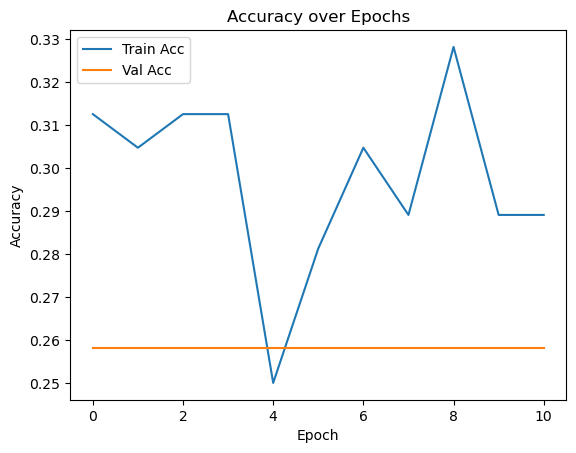

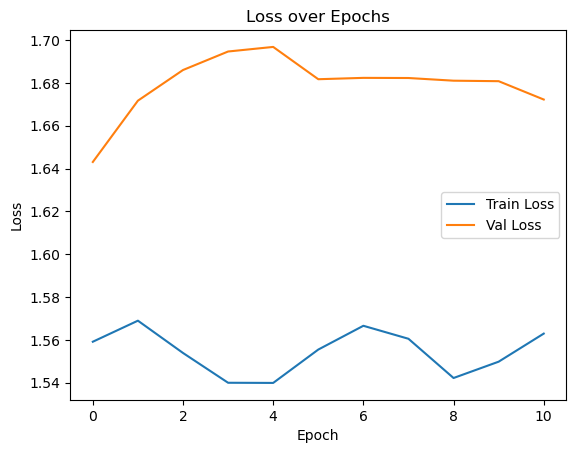

In [24]:
# Accuracy
plt.plot(history3.history['accuracy'], label='Train Acc')
plt.plot(history3.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

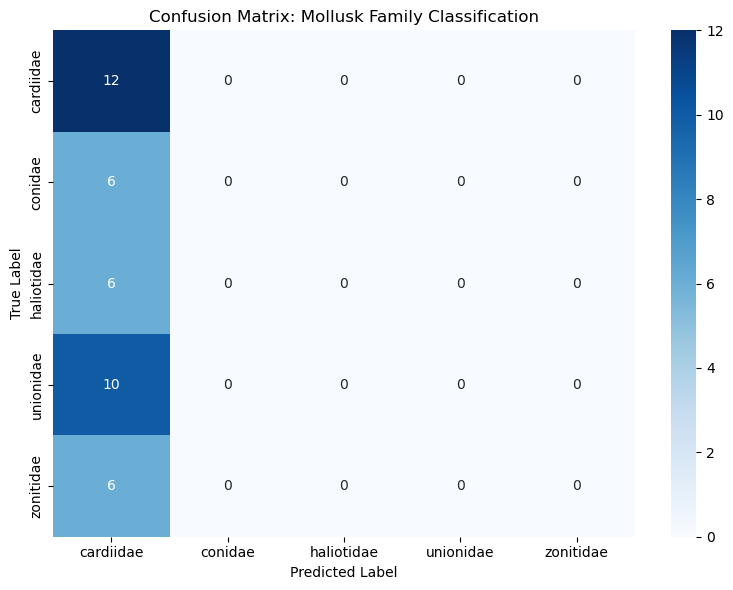

In [25]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model3.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [26]:
# 1. Evaluate on training set
train_loss, train_accuracy = model3.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = model3.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(model3, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 0.3125
Training Loss: 1.5466
Validation Accuracy: 0.2581
Validation Loss: 1.6430
Validation F1 Score: 0.0821


- Definitely need to use class weights next time
- Probably should try a more powerful version of EfficientNet next time

# 6. Hyperparameter Tuning <a class="anchor" id="hptuning"></a>

## 6.1. Hyperparameter Tuning for Custom Sequential Model <a class="anchor" id="hptcustomseq"></a>

In [ ]:
# Hyperparameter Grid 
optimizers_list = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-3, 1e-4, 1e-5]
dropouts = [0.2, 0.3, 0.4, 0.5]
dense_units = [64, 128, 256]
batch_sizes = [8, 16, 32]
image_sizes = [(128, 128), (224, 224)]
use_weights = [True, False]  # class imbalance handling

# Create all combinations
all_combinations = list(itertools.product(
    optimizers_list, learning_rates, dropouts,
    dense_units, batch_sizes, image_sizes, use_weights
))

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Randomly sample 50 combinations
sampled_combos = random.sample(all_combinations, k=50)

results = []

for i, (opt_name, lr, dropout, units, batch_size, image_size, use_weights) in enumerate(sampled_combos):
    print(f"\nCombo {i+1}/{len(sampled_combos)}: "
          f"opt={opt_name}, lr={lr}, dropout={dropout}, units={units}, "
          f"batch_size={batch_size}, image_size={image_size}, class_weight={use_weights}")

    # Create data generators
    train_generator, val_generator, _ = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,   
    batch_size=batch_size            
)

    # Build custom CNN
    model = models.Sequential([
        layers.Input(shape=(image_size[0], image_size[1], 3)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(5, activation='softmax')
    ])

    # Optimizer
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)
    elif opt_name == 'sgd':
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Compute class weights 
    class_weight = None
    if use_weights:
        y_labels = train_generator.classes  # Extract class indices
        class_weights_array = compute_class_weight(class_weight='balanced',
                                                   classes=np.unique(y_labels),
                                                   y=y_labels)
        class_weight = dict(enumerate(class_weights_array))

    # Train the model 
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        class_weight=class_weight,  
        verbose=0
    )

    # Record best val accuracy
    val_acc = max(history.history['val_accuracy'])
    print(f"Best Val Acc: {val_acc:.4f}")

    results.append({
        'optimizer': opt_name,
        'lr': lr,
        'dropout': dropout,
        'units': units,
        'batch_size': batch_size,
        'image_size': image_size,
        'class_weight': use_weights,
        'val_acc': val_acc
    })

# Create leaderboard 
df_results = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)
print("\nTop Configs:")
print(df_results.head(10))

# Execution time: 382m 55.1s


Combo 1/50: opt=rmsprop, lr=0.001, dropout=0.3, units=128, batch_size=8, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 2/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 3/50: opt=adam, lr=0.0001, dropout=0.3, units=256, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 4/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=128, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 5/50: opt=sgd, lr=0.001, dropout=0.5, units=64, batch_size=32, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 6/50: opt=adam, lr=1e-05, dropout=0.2, units=256, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 7/50: opt=adam, lr=0.0001, dropout=0.3, units=64, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 8/50: opt=adam, lr=0.001, dropout=0.5, units=256, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 9/50: opt=adam, lr=0.001, dropout=0.3, units=64, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 10/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=256, batch_size=16, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 11/50: opt=sgd, lr=0.0001, dropout=0.5, units=64, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.3226

Combo 12/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 13/50: opt=adam, lr=0.001, dropout=0.5, units=128, batch_size=8, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 14/50: opt=rmsprop, lr=0.001, dropout=0.2, units=128, batch_size=32, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 15/50: opt=sgd, lr=0.0001, dropout=0.3, units=128, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.3871

Combo 16/50: opt=sgd, lr=0.0001, dropout=0.4, units=128, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.6774

Combo 17/50: opt=rmsprop, lr=1e-05, dropout=0.2, units=128, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 18/50: opt=rmsprop, lr=0.001, dropout=0.5, units=256, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 19/50: opt=adam, lr=1e-05, dropout=0.3, units=256, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 20/50: opt=adam, lr=0.0001, dropout=0.4, units=64, batch_size=8, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 21/50: opt=rmsprop, lr=0.001, dropout=0.4, units=256, batch_size=32, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 22/50: opt=rmsprop, lr=0.001, dropout=0.2, units=64, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 23/50: opt=adam, lr=0.001, dropout=0.3, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 24/50: opt=rmsprop, lr=0.001, dropout=0.4, units=256, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 25/50: opt=rmsprop, lr=0.001, dropout=0.5, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 26/50: opt=adam, lr=1e-05, dropout=0.5, units=64, batch_size=8, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 27/50: opt=adam, lr=1e-05, dropout=0.3, units=128, batch_size=8, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 28/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=128, batch_size=32, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8387

Combo 29/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 30/50: opt=sgd, lr=1e-05, dropout=0.5, units=256, batch_size=8, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.4839

Combo 31/50: opt=rmsprop, lr=1e-05, dropout=0.3, units=64, batch_size=16, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 32/50: opt=adam, lr=0.0001, dropout=0.2, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 33/50: opt=sgd, lr=1e-05, dropout=0.4, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.3548

Combo 34/50: opt=rmsprop, lr=0.0001, dropout=0.5, units=64, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 35/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 36/50: opt=sgd, lr=0.0001, dropout=0.2, units=256, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 37/50: opt=rmsprop, lr=0.001, dropout=0.4, units=64, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 38/50: opt=adam, lr=1e-05, dropout=0.4, units=64, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 39/50: opt=rmsprop, lr=0.001, dropout=0.4, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8065

Combo 40/50: opt=sgd, lr=0.001, dropout=0.4, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 41/50: opt=rmsprop, lr=0.001, dropout=0.5, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 42/50: opt=adam, lr=0.0001, dropout=0.3, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 43/50: opt=sgd, lr=0.0001, dropout=0.5, units=64, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.5484

Combo 44/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 45/50: opt=adam, lr=0.001, dropout=0.2, units=128, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 46/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 47/50: opt=sgd, lr=1e-05, dropout=0.2, units=128, batch_size=32, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.2903

Combo 48/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=256, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 49/50: opt=sgd, lr=0.0001, dropout=0.2, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.2903

Combo 50/50: opt=adam, lr=1e-05, dropout=0.5, units=64, batch_size=8, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Top Configs:
   optimizer       lr  dropout  units  batch_size  image_size  class_weight  \
27   rmsprop  0.00010      0.3    128          32  (224, 224)          True   
38   rmsprop  0.00100      0.4     64           8  (224, 224)          True   
13   rmsprop  0.00100      0.2    128          32  (224, 224)          True   
6       adam  0.00010      0.3     64          16  (128, 128)          True   
31      adam  0.00010      0.2    256          32  (128, 128)         False   
41      adam  0.00010      0.3     64           8  (224, 224)          True   
47   rmsprop  0.00010      0.3    256           8  (224, 224)          True   
49      adam  0.00001      0.5     64           8  (224, 224)         False   
43   rmsprop  0.00010      0.3     64           8  (224, 224)          True   
37      adam  0.00001      0.4     64          16  (128, 128)          True   

     val_acc  
27  0.838710  
38  0.806452  
13  0.774194  
6   0.774194  
31  0.774194  
41  0

## 6.2. Train Custom Sequential with the Best Parameter Combinations <a class="anchor" id="traincustseq"></a>

In [33]:
# 1st combination of winning parameters
opt_name = 'rmsprop'
lr = 0.0001
dropout = 0.3
units = 128
batch_size = 32
image_size = (224, 224)
class_weight_on = True  

# Set seeds for reproducibility 
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Initialize data generators 
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,   
    mollusca_test,   
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Compute class weights
class_weight = None
if class_weight_on:
    y_labels = train_generator.classes  # get all class indices
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    class_weight = dict(enumerate(class_weights_array))
    

# Build custom CNN model 
modelA = models.Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(5, activation='softmax')  
])

# Compile model 
modelA.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [34]:
# Train model 
historyA = modelA.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], # Save based on the best validation loss
    verbose=1
)
#Execution time: 12m 37.2s

Epoch 1/50
4/4 [==============================] - 18s 5s/step - loss: 1.8479 - accuracy: 0.2188 - val_loss: 1.4189 - val_accuracy: 0.4194
Epoch 2/50
4/4 [==============================] - 16s 4s/step - loss: 1.4564 - accuracy: 0.3594 - val_loss: 1.3720 - val_accuracy: 0.4839
Epoch 3/50
4/4 [==============================] - 16s 4s/step - loss: 1.4018 - accuracy: 0.4531 - val_loss: 1.2520 - val_accuracy: 0.6129
Epoch 4/50
4/4 [==============================] - 16s 4s/step - loss: 1.3036 - accuracy: 0.4844 - val_loss: 1.1348 - val_accuracy: 0.6452
Epoch 5/50
4/4 [==============================] - 16s 4s/step - loss: 1.4146 - accuracy: 0.4844 - val_loss: 1.0758 - val_accuracy: 0.6452
Epoch 6/50
4/4 [==============================] - 16s 4s/step - loss: 1.2410 - accuracy: 0.4922 - val_loss: 1.0739 - val_accuracy: 0.5484
Epoch 7/50
4/4 [==============================] - 16s 4s/step - loss: 1.2414 - accuracy: 0.5312 - val_loss: 1.0470 - val_accuracy: 0.5806
Epoch 8/50
4/4 [==================

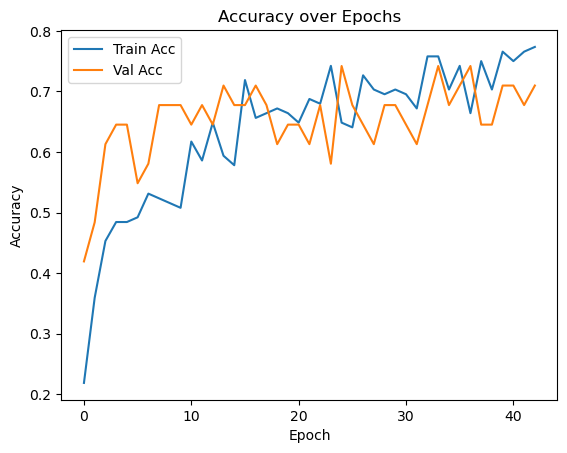

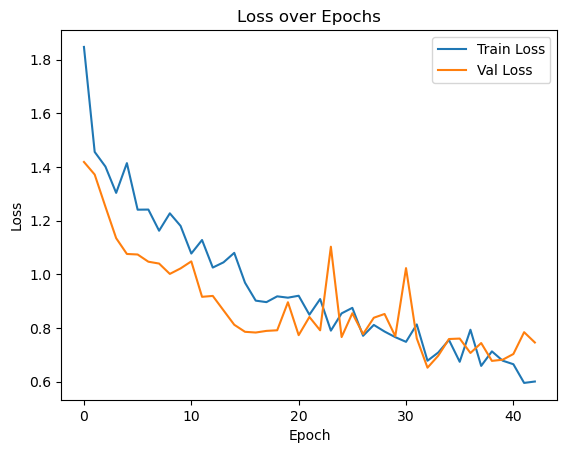

In [35]:
# Plot Accuracy 
plt.plot(historyA.history['accuracy'], label='Train Acc')
plt.plot(historyA.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.plot(historyA.history['loss'], label='Train Loss')
plt.plot(historyA.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Save after 16**

In [36]:
# 1st combination of winning parameters
opt_name = 'rmsprop'
lr = 0.0001
dropout = 0.3
units = 128
batch_size = 32
image_size = (224, 224)
class_weight_on = True  

# Set seeds for reproducibility 
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Initialize data generators 
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,   
    mollusca_test,   
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Compute class weights
class_weight = None
if class_weight_on:
    y_labels = train_generator.classes  # get all class indices
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    class_weight = dict(enumerate(class_weights_array))
    

# Build custom CNN model 
modelA = models.Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(5, activation='softmax')  
])

# Compile model 
modelA.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [37]:
# Train model 
historyA = modelA.fit(
    train_generator,
    validation_data=val_generator,
    epochs=16,
    verbose=1
)
#Execution time: 12m 37.2s

Epoch 1/16
4/4 [==============================] - 39s 10s/step - loss: 1.8479 - accuracy: 0.2188 - val_loss: 1.4189 - val_accuracy: 0.4194
Epoch 2/16
4/4 [==============================] - 34s 9s/step - loss: 1.4564 - accuracy: 0.3594 - val_loss: 1.3720 - val_accuracy: 0.4839
Epoch 3/16
4/4 [==============================] - 34s 8s/step - loss: 1.4018 - accuracy: 0.4531 - val_loss: 1.2520 - val_accuracy: 0.6129
Epoch 4/16
4/4 [==============================] - 34s 9s/step - loss: 1.3036 - accuracy: 0.4844 - val_loss: 1.1348 - val_accuracy: 0.6452
Epoch 5/16
4/4 [==============================] - 35s 8s/step - loss: 1.4146 - accuracy: 0.4844 - val_loss: 1.0758 - val_accuracy: 0.6452
Epoch 6/16
4/4 [==============================] - 35s 8s/step - loss: 1.2410 - accuracy: 0.4922 - val_loss: 1.0739 - val_accuracy: 0.5484
Epoch 7/16
4/4 [==============================] - 38s 9s/step - loss: 1.2414 - accuracy: 0.5312 - val_loss: 1.0470 - val_accuracy: 0.5806
Epoch 8/16
4/4 [=================

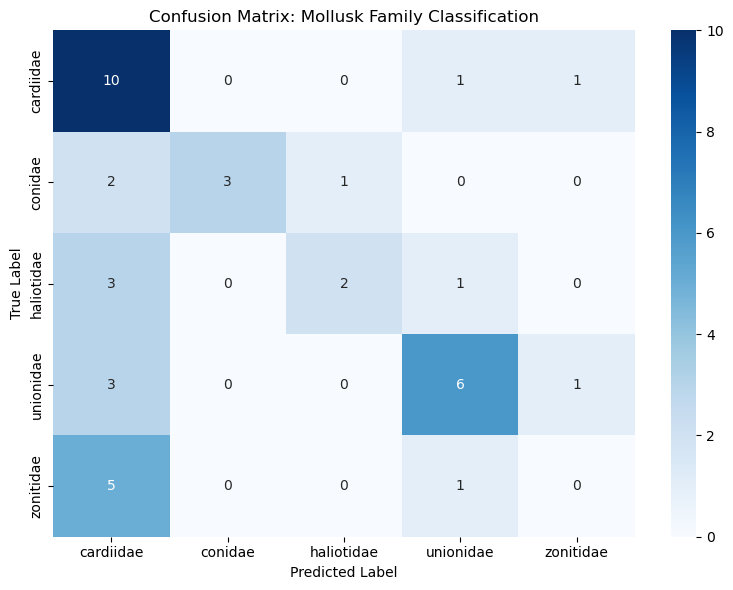

In [38]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = modelA.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [39]:
# 1. Evaluate on training set
train_loss, train_accuracy = modelA.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = modelA.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(modelA, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 0.7656
Training Loss: 0.8298
Validation Accuracy: 0.6452
Validation Loss: 0.8106
Validation F1 Score: 0.2153


In [40]:
# 2nd best combo of parameters
opt_name = 'rmsprop'
lr = 0.001
dropout = 0.4
units = 64
batch_size = 8
image_size = (224, 224)
class_weight_on = True  

# Set seeds for reproducibility 
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Initialize data generators 
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,   
    mollusca_test,   
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Compute class weights
class_weight = None
if class_weight_on:
    y_labels = train_generator.classes  # get all class indices
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    class_weight = dict(enumerate(class_weights_array))
    

# Build custom CNN model 
modelB = models.Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(5, activation='softmax')  
])

# Compile model
modelB.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [41]:
# Train model 
historyB = modelB.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], # Save based on the best validation loss
    verbose=1
)
#Execution time: 18m 37.2s

Epoch 1/50
16/16 [==============================] - 40s 2s/step - loss: 2.6376 - accuracy: 0.2188 - val_loss: 1.5575 - val_accuracy: 0.4839
Epoch 2/50
16/16 [==============================] - 37s 2s/step - loss: 1.5505 - accuracy: 0.2969 - val_loss: 1.5045 - val_accuracy: 0.3871
Epoch 3/50
16/16 [==============================] - 34s 2s/step - loss: 1.5597 - accuracy: 0.3281 - val_loss: 1.0831 - val_accuracy: 0.6129
Epoch 4/50
16/16 [==============================] - 30s 2s/step - loss: 1.4896 - accuracy: 0.4141 - val_loss: 1.2382 - val_accuracy: 0.6129
Epoch 5/50
16/16 [==============================] - 28s 2s/step - loss: 1.4361 - accuracy: 0.4219 - val_loss: 1.2298 - val_accuracy: 0.6452
Epoch 6/50
16/16 [==============================] - 29s 2s/step - loss: 1.4082 - accuracy: 0.4219 - val_loss: 1.0621 - val_accuracy: 0.6452
Epoch 7/50
16/16 [==============================] - 34s 2s/step - loss: 1.2972 - accuracy: 0.5156 - val_loss: 0.8738 - val_accuracy: 0.6774
Epoch 8/50
16/16 [==

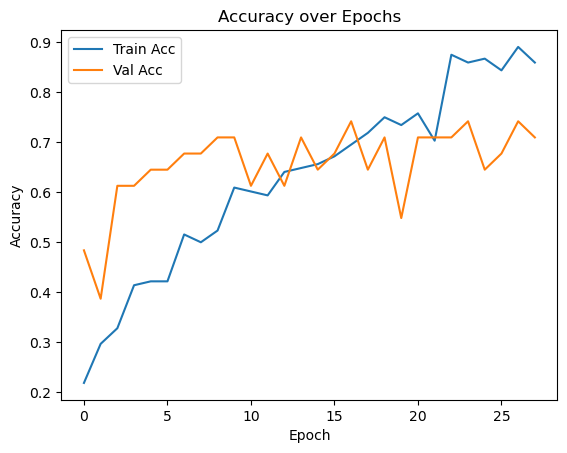

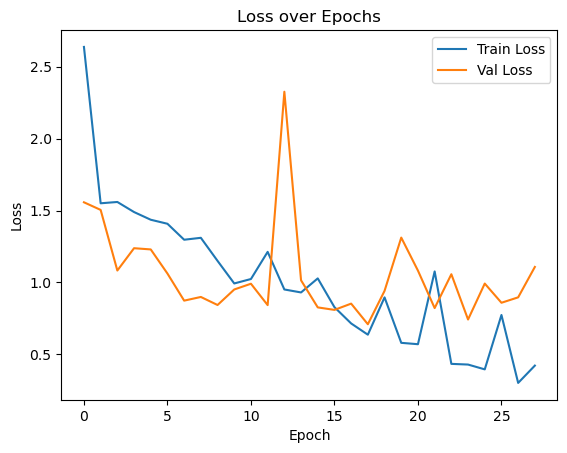

In [42]:
# Plot Accuracy 
plt.plot(historyB.history['accuracy'], label='Train Acc')
plt.plot(historyB.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.plot(historyB.history['loss'], label='Train Loss')
plt.plot(historyB.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Save after 17 epochs**

In [8]:
# 2nd best combo of parameters
opt_name = 'rmsprop'
lr = 0.001
dropout = 0.4
units = 64
batch_size = 8
image_size = (224, 224)
class_weight_on = True  

# Set seeds for reproducibility 
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Initialize data generators 
train_generator, val_generator, test_generator = create_generators(
    train_df=mollusca_train,   
    test_df=mollusca_test,   
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Compute class weights
class_weight = None
if class_weight_on:
    y_labels = train_generator.classes  # get all class indices
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    class_weight = dict(enumerate(class_weights_array))
    

# Build custom CNN model 
modelB = models.Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(5, activation='softmax')  
])

# Compile model
modelB.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [9]:
# Train model 
historyB = modelB.fit(
    train_generator,
    validation_data=val_generator,
    epochs=17,
    verbose=1
)
#Execution time: 18m 37.2s

Epoch 1/17
16/16 [==============================] - 19s 1s/step - loss: 2.6376 - accuracy: 0.2188 - val_loss: 1.5575 - val_accuracy: 0.4839
Epoch 2/17
16/16 [==============================] - 27s 2s/step - loss: 1.5505 - accuracy: 0.2969 - val_loss: 1.5045 - val_accuracy: 0.3871
Epoch 3/17
16/16 [==============================] - 30s 2s/step - loss: 1.5597 - accuracy: 0.3281 - val_loss: 1.0831 - val_accuracy: 0.6129
Epoch 4/17
16/16 [==============================] - 27s 2s/step - loss: 1.4896 - accuracy: 0.4141 - val_loss: 1.2382 - val_accuracy: 0.6129
Epoch 5/17
16/16 [==============================] - 29s 2s/step - loss: 1.4361 - accuracy: 0.4219 - val_loss: 1.2298 - val_accuracy: 0.6452
Epoch 6/17
16/16 [==============================] - 24s 1s/step - loss: 1.4082 - accuracy: 0.4219 - val_loss: 1.0621 - val_accuracy: 0.6452
Epoch 7/17
16/16 [==============================] - 29s 2s/step - loss: 1.2972 - accuracy: 0.5156 - val_loss: 0.8738 - val_accuracy: 0.6774
Epoch 8/17
16/16 [==

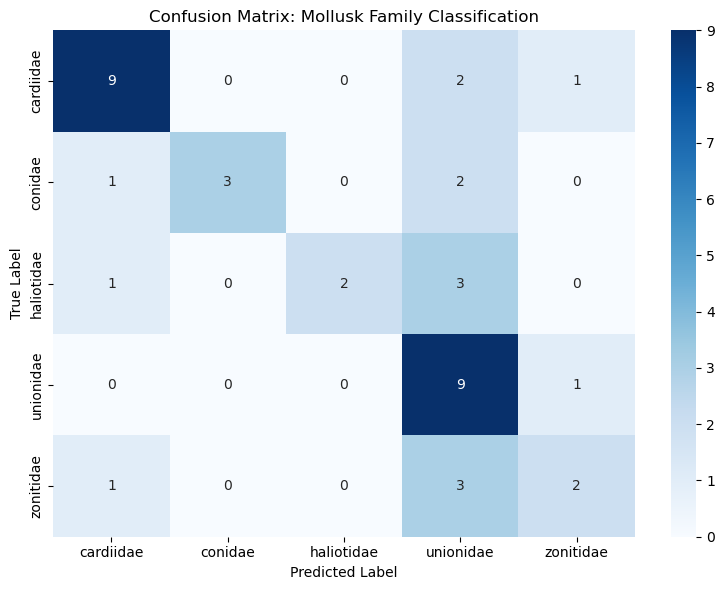

In [10]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = modelB.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [11]:
# 1. Evaluate on training set
train_loss, train_accuracy = modelB.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = modelB.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(modelB, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 0.7344
Training Loss: 0.6641
Validation Accuracy: 0.7097
Validation Loss: 0.9017
Validation F1 Score: 0.1206


In [47]:
# 3rd best combo of parameters
opt_name = 'rmsprop'
lr = 0.001
dropout = 0.2
units = 128
batch_size = 32
image_size = (224, 224)
class_weight_on = True  

# Set seeds for reproducibility 
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Initialize data generators 
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,   
    mollusca_test,   
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Compute class weights
class_weight = None
if class_weight_on:
    y_labels = train_generator.classes  # get all class indices
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    class_weight = dict(enumerate(class_weights_array))
    

# Build custom CNN model 
modelC = models.Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(5, activation='softmax')  
])

# Compile model 
modelC.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [48]:
# Train model 
historyC = modelC.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], # Save based on the best validation loss
    verbose=1
)
#Execution time: 17m 10.3s

Epoch 1/50
4/4 [==============================] - 32s 8s/step - loss: 8.0638 - accuracy: 0.1875 - val_loss: 1.5425 - val_accuracy: 0.2581
Epoch 2/50
4/4 [==============================] - 35s 9s/step - loss: 2.1615 - accuracy: 0.2656 - val_loss: 1.4786 - val_accuracy: 0.4194
Epoch 3/50
4/4 [==============================] - 37s 9s/step - loss: 1.4906 - accuracy: 0.3828 - val_loss: 1.2515 - val_accuracy: 0.5161
Epoch 4/50
4/4 [==============================] - 38s 10s/step - loss: 1.4108 - accuracy: 0.4219 - val_loss: 1.1188 - val_accuracy: 0.6452
Epoch 5/50
4/4 [==============================] - 40s 10s/step - loss: 2.1260 - accuracy: 0.3516 - val_loss: 1.1403 - val_accuracy: 0.4516
Epoch 6/50
4/4 [==============================] - 36s 9s/step - loss: 1.4755 - accuracy: 0.3281 - val_loss: 1.1534 - val_accuracy: 0.6129
Epoch 7/50
4/4 [==============================] - 37s 9s/step - loss: 1.3496 - accuracy: 0.4375 - val_loss: 1.0366 - val_accuracy: 0.7097
Epoch 8/50
4/4 [================

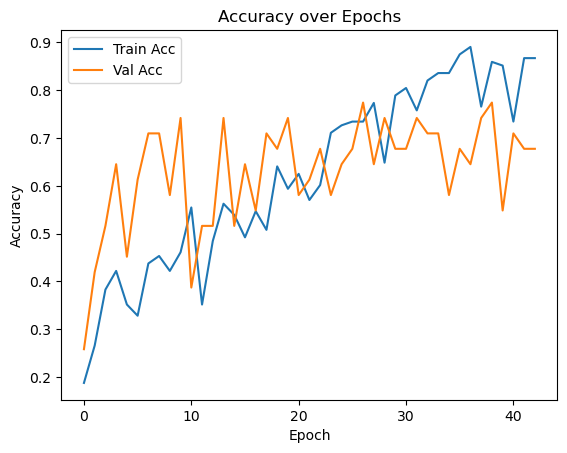

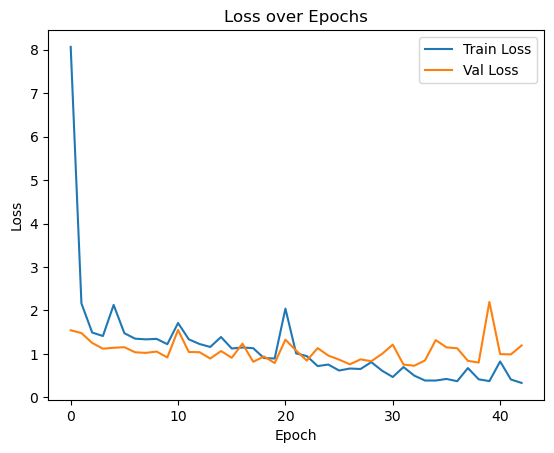

In [49]:
# Plot Accuracy 
plt.plot(historyC.history['accuracy'], label='Train Acc')
plt.plot(historyC.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.plot(historyC.history['loss'], label='Train Loss')
plt.plot(historyC.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Save the one after 32 epochs**

In [50]:
# 3rd best combo of parameters
opt_name = 'rmsprop'
lr = 0.001
dropout = 0.2
units = 128
batch_size = 32
image_size = (224, 224)
class_weight_on = True  

# Set seeds for reproducibility 
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Initialize data generators 
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,   
    mollusca_test,   
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Compute class weights
class_weight = None
if class_weight_on:
    y_labels = train_generator.classes  # get all class indices
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    class_weight = dict(enumerate(class_weights_array))
    

# Build custom CNN model 
modelC = models.Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(5, activation='softmax')  
])

# Compile model 
modelC.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [51]:
# Train model 
historyC = modelC.fit(
    train_generator,
    validation_data=val_generator,
    epochs=32,
    verbose=1
)
#Execution time: 17m 10.3s

Epoch 1/32
4/4 [==============================] - 37s 9s/step - loss: 8.0638 - accuracy: 0.1875 - val_loss: 1.5425 - val_accuracy: 0.2581
Epoch 2/32
4/4 [==============================] - 35s 9s/step - loss: 2.1615 - accuracy: 0.2656 - val_loss: 1.4786 - val_accuracy: 0.4194
Epoch 3/32
4/4 [==============================] - 39s 10s/step - loss: 1.4906 - accuracy: 0.3828 - val_loss: 1.2515 - val_accuracy: 0.5161
Epoch 4/32
4/4 [==============================] - 34s 9s/step - loss: 1.4108 - accuracy: 0.4219 - val_loss: 1.1188 - val_accuracy: 0.6452
Epoch 5/32
4/4 [==============================] - 37s 9s/step - loss: 2.1260 - accuracy: 0.3516 - val_loss: 1.1403 - val_accuracy: 0.4516
Epoch 6/32
4/4 [==============================] - 37s 9s/step - loss: 1.4755 - accuracy: 0.3281 - val_loss: 1.1534 - val_accuracy: 0.6129
Epoch 7/32
4/4 [==============================] - 35s 9s/step - loss: 1.3496 - accuracy: 0.4375 - val_loss: 1.0366 - val_accuracy: 0.7097
Epoch 8/32
4/4 [=================

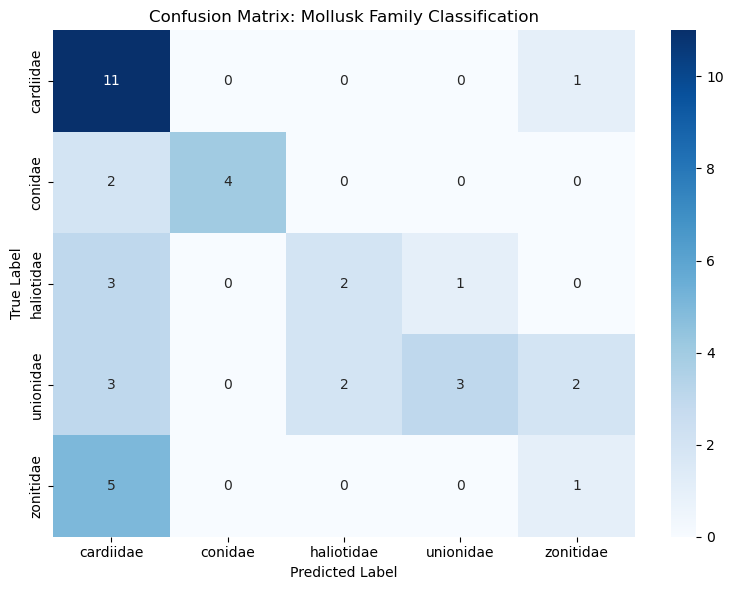

In [52]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = modelC.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [53]:
# 1. Evaluate on training set
train_loss, train_accuracy = modelC.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = modelC.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(modelC, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 0.8438
Training Loss: 0.4293
Validation Accuracy: 0.7419
Validation Loss: 0.8208
Validation F1 Score: 0.1602


## 6.3. Save the Best Custom Sequential Model <a class="anchor" id="savecustseq"></a>

In [22]:
# Save Model 
modelB.save("models/mollusca_models/custom_sequential.h5")
print("Model saved to models/mollusca_models/custom_sequential.h5")

Model saved to models/mollusca_models/custom_sequential.h5


## 6.4. Hyperparameter Tuning for MobileNetV2<a class="anchor" id="hptMobileNetV2"></a>

In [55]:
# Define hyperparameter grid
optimizers_list = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-3, 1e-4, 1e-5]
dropouts = [0.2, 0.3, 0.4, 0.5]
dense_units = [64, 128, 256]
batch_sizes = [8, 16, 32]
image_sizes = [(128, 128), (224, 224)]  

# Create all combinations
all_combinations = list(itertools.product(
    optimizers_list, learning_rates, dropouts,
    dense_units, batch_sizes, image_sizes
))

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Randomly sample 50 combinations
sampled_combos = random.sample(all_combinations, k=50)

# Initialize results list
results = []

for i, (opt_name, lr, dropout, units, batch_size, image_size) in enumerate(sampled_combos):
    print(f"\nCombo {i+1}/{len(sampled_combos)}: "
          f"opt={opt_name}, lr={lr}, dropout={dropout}, units={units}, "
          f"batch_size={batch_size}, image_size={image_size}")

    # Create generators for this batch_size and image_size
    train_generator, val_generator, _ = create_generators(
        mollusca_train,
        mollusca_test,
        image_root_dir=image_root_dir,
        image_size=image_size,   
        batch_size=batch_size
    )

    # Load MobileNetV2 with current image_size
    base_model = MobileNetV2(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )

    # Always freeze all layers
    base_model.trainable = False

    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(units, activation='relu'),
        layers.Dense(5, activation='softmax')  
    ])

    # Select optimizer
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)
    elif opt_name == 'sgd':
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Compile model
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )

    # Record best validation accuracy
    val_acc = max(history.history['val_accuracy'])
    print(f"Best Val Acc: {val_acc:.4f}")

    results.append({
        'optimizer': opt_name,
        'lr': lr,
        'dropout': dropout,
        'units': units,
        'batch_size': batch_size,
        'image_size': image_size,
        'val_acc': val_acc
    })

# Create leaderboard
df_results = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)
print("\nTop Configs:")
print(df_results.head(10))


# Execution time: 362m 23.5s


Combo 1/50: opt=rmsprop, lr=0.001, dropout=0.3, units=128, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Best Val Acc: 0.9677

Combo 2/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Best Val Acc: 0.9032

Combo 3/50: opt=adam, lr=0.0001, dropout=0.3, units=256, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Best Val Acc: 0.9355

Combo 4/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=128, batch_size=16, image_size=(224, 224)
Found 128 validate

## 6.5. Train MobileNetV2 with the Best Parameter Combination<a class="anchor" id="trainbestparmobilenet"></a>

In [21]:
# Winning hyperparameter configuration 
opt_name = 'rmsprop'
lr = 0.001
dropout = 0.3
units = 128
batch_size = 8
image_size = (224, 224)

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Load base model
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
base_model.trainable = False

# Build full model
modelD = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  
])

# Compile model
modelD.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [22]:
# Train
historyD = modelD.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)
# Execution time: 12m 36.5s

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step - accuracy: 0.4829 - loss: 1.8978 - val_accuracy: 0.8065 - val_loss: 0.5592
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.9287 - loss: 0.2877 - val_accuracy: 0.9032 - val_loss: 0.3348
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.9583 - loss: 0.1786 - val_accuracy: 0.8710 - val_loss: 0.4132
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.9282 - loss: 0.1977 - val_accuracy: 0.9032 - val_loss: 0.2419
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.9747 - loss: 0.0628 - val_accuracy: 0.9032 - val_loss: 0.2849
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.9962 - loss: 0.0307 - val_accuracy: 0.9032 - val_loss: 0.2349
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 1.0000 - loss: 0.0230 - val_accuracy: 0.9355 - val_loss: 0.2485
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.9955 - loss: 0.0237 - val_accuracy: 0

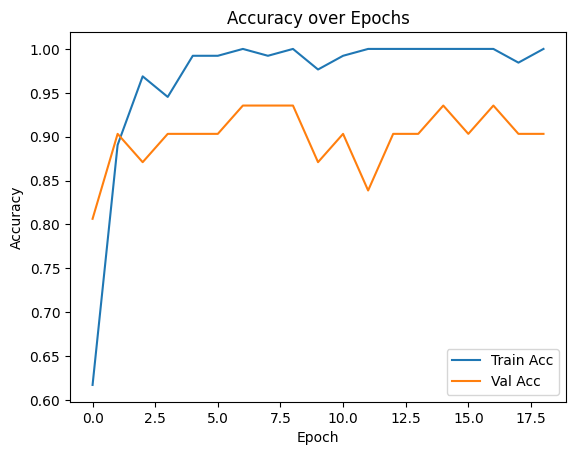

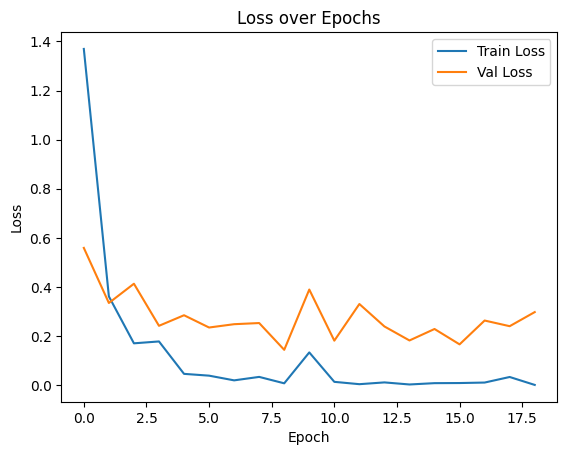

In [23]:
# Accuracy
plt.plot(historyD.history['accuracy'], label='Train Acc')
plt.plot(historyD.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(historyD.history['loss'], label='Train Loss')
plt.plot(historyD.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Save the one after 2 epochs**

In [24]:
# 1st combo of winning parameters 
opt_name = 'rmsprop'
lr = 0.001
dropout = 0.3
units = 128
batch_size = 8
image_size = (224, 224)

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Load base model
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
base_model.trainable = False

# Build full model
modelD = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  
])

# Compile model
modelD.compile(
    optimizer=optimizers.RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [25]:
# Train
historyD = modelD.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    verbose=1
)
# Execution time: 12m 36.5s

Epoch 1/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 537ms/step - accuracy: 0.4829 - loss: 1.8978 - val_accuracy: 0.8065 - val_loss: 0.5592
Epoch 2/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.9287 - loss: 0.2877 - val_accuracy: 0.9032 - val_loss: 0.3348


2025-04-30 13:10:48.155330: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-30 13:10:48.361406: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-30 13:10:48.567267: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


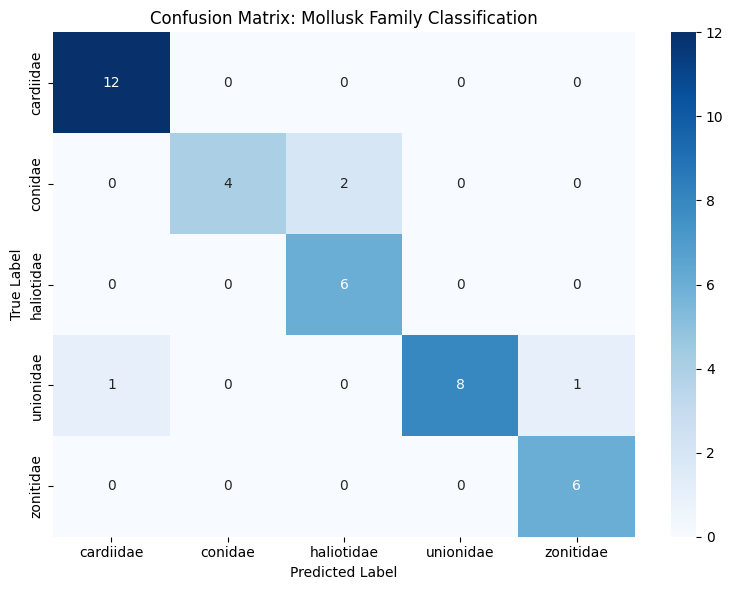

In [26]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = modelD.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [27]:
# 1. Evaluate on training set
train_loss, train_accuracy = modelD.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = modelD.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(modelD, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 0.8672
Training Loss: 0.2687
Validation Accuracy: 0.8387
Validation Loss: 0.3575
Validation F1 Score: 0.1678


In [28]:
# Winning hyperparameter configuration 
opt_name = 'sgd'
lr = 0.001
dropout = 0.5
units = 64
batch_size = 32
image_size = (128, 128)

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Load base model
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
base_model.trainable = False

# Build full model
modelE = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Compile model 
modelE.compile(
    optimizer=optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
# Train
historyE = modelE.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)
# Execution time: 12m 36.5s

Epoch 1/50


2025-04-30 13:11:12.043524: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6658', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 13:11:15.842003: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-30 13:11:16.066526: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1165 - loss: 2.3246

2025-04-30 13:11:22.276256: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 220 bytes spill stores, 220 bytes spill loads

2025-04-30 13:11:22.604902: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 13:11:22.820991: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5356 bytes spill stores, 5412 bytes spill loads

2025-04-30 13:11:23.007758: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5332 bytes spill stores, 5316 bytes spill loads

2025-04-30 13:11:27.782888: E ex

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.1229 - loss: 2.3077 - val_accuracy: 0.0968 - val_loss: 1.8571
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1667 - loss: 2.2133 - val_accuracy: 0.2903 - val_loss: 1.5344
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step - accuracy: 0.3594 - loss: 1.7634 - val_accuracy: 0.5161 - val_loss: 1.2808
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - accuracy: 0.4448 - loss: 1.5366 - val_accuracy: 0.6129 - val_loss: 1.1630
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 810ms/step - accuracy: 0.5073 - loss: 1.3506 - val_accuracy: 0.6774 - val_loss: 0.8869
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step - accuracy: 0.5104 - loss: 1.2736 - val_accuracy: 0.7419 - val_loss: 0.7715
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step - accuracy: 0.6208 - loss: 0.9719 - val_accuracy: 0.7097 - val_loss: 0.7750
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step - accuracy: 0.6677 - loss: 0.9194 - val_accuracy: 0.8065 - val_loss: 0.7181
Epoch 9/

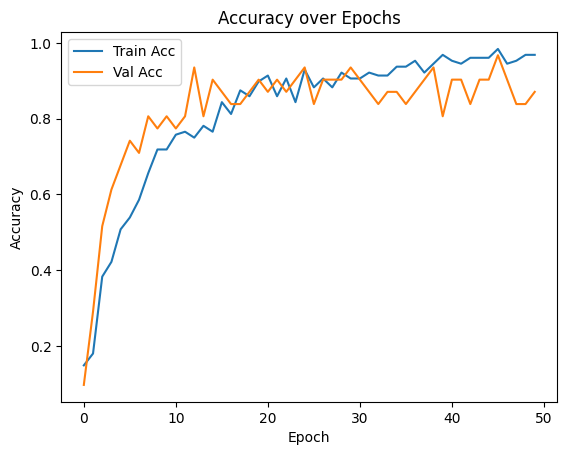

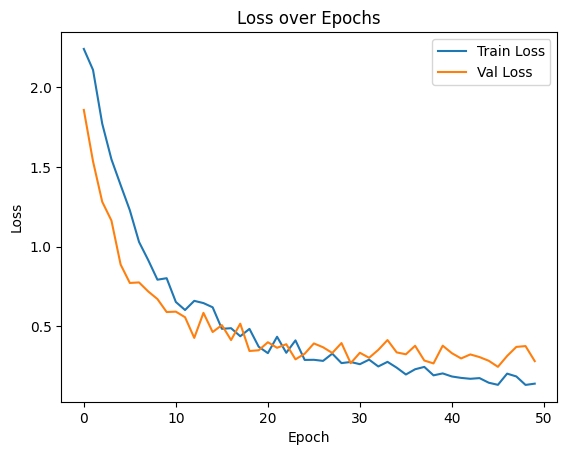

In [30]:
# Accuracy
plt.plot(historyE.history['accuracy'], label='Train Acc')
plt.plot(historyE.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(historyE.history['loss'], label='Train Loss')
plt.plot(historyE.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Save the one after 15 epochs**

In [14]:
# Winning hyperparameter configuration 
opt_name = 'sgd'
lr = 0.001
dropout = 0.5
units = 64
batch_size = 32
image_size = (128, 128)

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Load base model
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
base_model.trainable = False

# Build full model
modelE = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Compile model 
modelE.compile(
    optimizer=optimizers.SGD(learning_rate=lr, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [15]:
# Train
historyE = modelE.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    verbose=1
)
# Execution time: 12m 36.5s

Epoch 1/15
4/4 [==============================] - 20s 3s/step - loss: 3.3409 - accuracy: 0.1719 - val_loss: 1.6809 - val_accuracy: 0.3226
Epoch 2/15
4/4 [==============================] - 14s 4s/step - loss: 2.1983 - accuracy: 0.2422 - val_loss: 1.4389 - val_accuracy: 0.3871
Epoch 3/15
4/4 [==============================] - 11s 3s/step - loss: 1.6545 - accuracy: 0.3594 - val_loss: 1.5114 - val_accuracy: 0.5484
Epoch 4/15
4/4 [==============================] - 10s 3s/step - loss: 1.5734 - accuracy: 0.4766 - val_loss: 1.4594 - val_accuracy: 0.5484
Epoch 5/15
4/4 [==============================] - 11s 3s/step - loss: 1.3673 - accuracy: 0.5312 - val_loss: 1.3228 - val_accuracy: 0.6129
Epoch 6/15
4/4 [==============================] - 10s 2s/step - loss: 1.2008 - accuracy: 0.5703 - val_loss: 1.0469 - val_accuracy: 0.6452
Epoch 7/15
4/4 [==============================] - 8s 2s/step - loss: 0.9750 - accuracy: 0.6406 - val_loss: 0.8893 - val_accuracy: 0.6774
Epoch 8/15
4/4 [===================

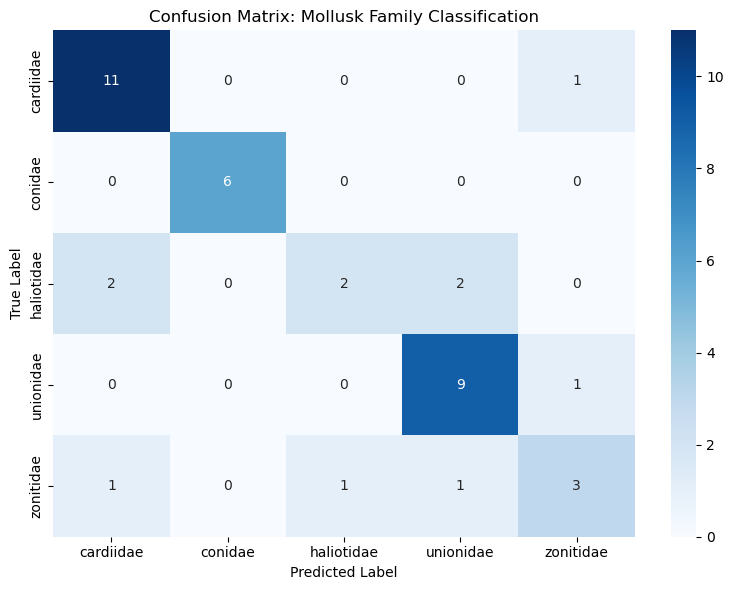

In [16]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = modelE.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [17]:
# 1. Evaluate on training set
train_loss, train_accuracy = modelE.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = modelE.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(modelE, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

Training Accuracy: 0.9219
Training Loss: 0.3375
Validation Accuracy: 0.8710
Validation Loss: 0.5385
Validation F1 Score: 0.2027


In [35]:
# 3rd best hyperparameter configuration 
opt_name = 'adam'
lr = 0.001
dropout = 0.5
units = 256
batch_size = 16
image_size = (128, 128)

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Load base model
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
base_model.trainable = False

# Build full model
modelF = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  
])

# Compile model 
modelF.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [36]:
# Train
historyF = modelF.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)
# Execution time: 12m 36.5s

Epoch 1/50


2025-04-30 13:15:15.903016: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-30 13:15:16.147813: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-30 13:15:16.412731: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-30 13:15:16.605569: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.100 = (f32[16,960,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,960,4,4]{3,2,1,0} %bitcast.9040, f32[960,1,3,3]{3,2,1,0} %bitcast.9047), window={size=3x3 pad=

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4924 - loss: 1.5835

2025-04-30 13:15:22.830427: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 4 bytes spill stores, 4 bytes spill loads

2025-04-30 13:15:23.101560: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195_0', 200 bytes spill stores, 536 bytes spill loads

2025-04-30 13:15:23.229163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 116 bytes spill stores, 116 bytes spill loads

2025-04-30 13:15:23.612177: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5356 bytes spill stores, 5416 bytes spill loads

2025-04-30 13:15:23.830224: I ex

8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4984 - loss: 1.5578 - val_accuracy: 0.8387 - val_loss: 0.4529
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.7850 - loss: 0.5710 - val_accuracy: 0.9032 - val_loss: 0.3316
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.9126 - loss: 0.2435 - val_accuracy: 0.9032 - val_loss: 0.2584
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.9504 - loss: 0.1523 - val_accuracy: 0.8710 - val_loss: 0.2008
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9744 - loss: 0.0848 - val_accuracy: 0.8710 - val_loss: 0.2665
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.9779 - loss: 0.0661 - val_accuracy: 0.9032 - val_loss: 0.2118
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - accuracy: 0.9435 - loss: 0.1160 - val_accuracy: 0.9677 - val_loss: 0.1562
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.9907 - loss: 0.0465 - val_accuracy: 0.9032 - val_loss: 0.2761
Epoch

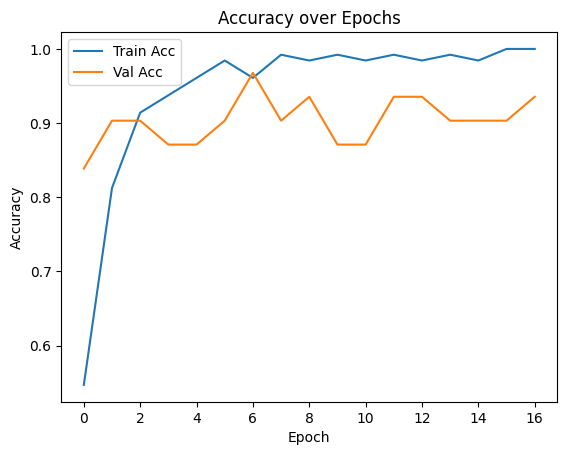

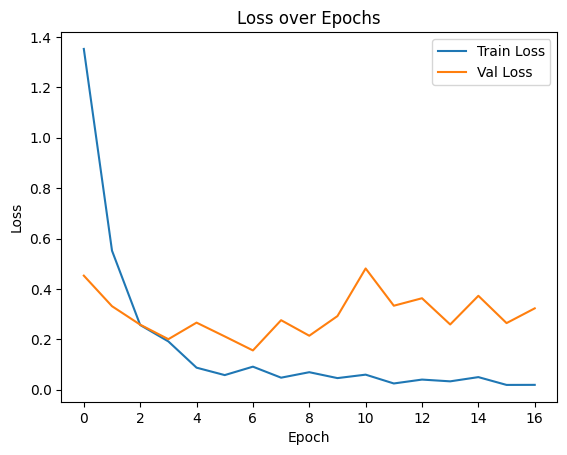

In [37]:
# Accuracy
plt.plot(historyF.history['accuracy'], label='Train Acc')
plt.plot(historyF.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(historyF.history['loss'], label='Train Loss')
plt.plot(historyF.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
# 3rd best hyperparameter configuration 
opt_name = 'adam'
lr = 0.001
dropout = 0.5
units = 256
batch_size = 16
image_size = (128, 128)

# Set random seeds for reproducibility
random.seed(4)
np.random.seed(4)
tf.random.set_seed(4)

# Create data generators
train_generator, val_generator, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Load base model
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
base_model.trainable = False

# Build full model
modelF = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  
])

# Compile model 
modelF.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [39]:
# Train
historyF = modelF.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    verbose=1
)
# Execution time: 12m 36.5s

Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4984 - loss: 1.5578 - val_accuracy: 0.8387 - val_loss: 0.4529
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.7850 - loss: 0.5710 - val_accuracy: 0.9032 - val_loss: 0.3316
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.9126 - loss: 0.2435 - val_accuracy: 0.9032 - val_loss: 0.2584


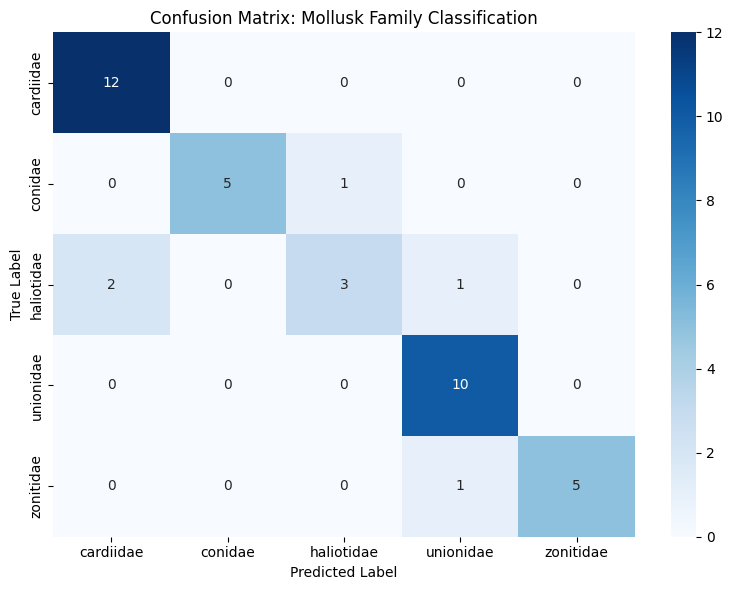

In [40]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = modelE.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [41]:
# 1. Evaluate on training set
train_loss, train_accuracy = modelE.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# 2. Evaluate on validation set
val_loss, val_accuracy = modelE.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# 3. Evaluate F1 score on validation set
val_f1 = evaluate_f1(modelE, val_generator)
print(f"Validation F1 Score: {val_f1:.4f}")

2025-04-30 13:16:53.686824: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 116 bytes spill stores, 116 bytes spill loads

2025-04-30 13:16:54.179089: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5356 bytes spill stores, 5416 bytes spill loads

2025-04-30 13:16:54.360381: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5216 bytes spill stores, 5212 bytes spill loads



Training Accuracy: 0.9375
Training Loss: 0.3399


2025-04-30 13:17:00.352125: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 13:17:00.654538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 112 bytes spill stores, 112 bytes spill loads

2025-04-30 13:17:00.808235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 8 bytes spill stores, 8 bytes spill loads

2025-04-30 13:17:01.452170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 5292 bytes spill stores, 5348 bytes spill loads

2025-04-30 13:17:01.552100: I external

Validation Accuracy: 0.8710
Validation Loss: 0.4741
Validation F1 Score: 0.2547


## 6.6. Save the Best MobileNetV2 Model <a class="anchor" id="savebestmobilenet"></a>

In [21]:
# Save
modelE.save("models/mollusca_models/best_mobilenetv2.h5")
print("Model saved to models/mollusca_models/best_mobilenetv2.h5")

Model saved to models/mollusca_models/best_mobilenetv2.h5


# 7. Test the Models <a class="anchor" id="test"></a>

## 7.1. Test Custom Sequential Model <a class="anchor" id="testcustomseq"></a>

In [23]:
# Load custom sequential model
model = load_model("models/mollusca_models/custom_sequential.h5")

# Initialize generators with (224, 224)
image_size = (224, 224)  
batch_size = 1   

_, _, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Evaluate accuracy and loss on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Compute F1 score 
test_f1 = evaluate_f1(model, test_generator)
print(f"Test F1 Score: {test_f1:.4f}")

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Test Accuracy: 0.6250
Test Loss: 1.2047
Test F1 Score: 0.5875


## 7.2. Test MobileNetV2 <a class="anchor" id="testMobileNetV2"></a>

In [24]:
# Load MobileNetV2
model = load_model("models/mollusca_models/best_mobilenetv2.h5")

# Initialize generators with (128, 128)
image_size = (128, 128) 
batch_size = 1  

_, _, test_generator = create_generators(
    mollusca_train,
    mollusca_test,
    image_root_dir=image_root_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Evaluate accuracy and loss on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Compute F1 score 
test_f1 = evaluate_f1(model, test_generator)
print(f"Test F1 Score: {test_f1:.4f}")

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Test Accuracy: 0.7750
Test Loss: 0.6414
Test F1 Score: 0.7308
